#  <span style='color:blue'> Mise en place des méthodes d’identification des contrefaçons des billets en euros pour ONGFM

Notre entreprise a décroché une prestation en régie au sein de l’Organisation nationale de lutte contre le faux-monnayage (ONCFM) : mettre en place des méthodes d’identification des contrefaçons des billets en euros. 
ONCFM a observé des différences de dimensions entre les vrais et les faux billets qui sont difficilement notables à l’œil nu.
De ce fait, à partir des caractéristiques géométriques d’un billet il faudrait construire un algorithme qui serait capable de définir si ce dernier est un vrai ou un faux billet.

Nous allons voir comment mettre en place une modélisation qui serait capable d’identifier automatiquement les vrais et les faux billets.

##  <span style='color:blue'> Sommaire
* [I. Néttoyage des données](#Nettoyage)
* [II. Analyse descriptive des données](#Analyse)
    * [2.1 Répartition des dimensions des billets par groupe (vraix / faux)](#rep)
    * [2.2 Distribution des billets en fonction de caractéristiques géometriques par groupe (vrais / faux)](#dist)
    * [2.3 Clustering et analyse de centroïdes](#clustering)
    * [2.4 ACP](#acp)
* [III. Différentes pistes explorées pour la construction de l’algorithme](#algorithme)
    * [3.1 Régression logistique classique](#reglog)
    * [3.2 Modèle K-NN](#knn)
* [IV. Modèle retenu](#model)
* [V. Test de l'algorithme](#test)

##  <span style='color:blue'> I. Nettoyage des données <a class="anchor" id="Nettoyage"></a>

Nous allons importer les données 'billets', ensuite nous allons effectuer l'inspection de ces données.

In [1]:
import pandas as pd
billets = pd.read_csv("billets.csv", sep=";")
billets.info() # 6 dimentions sont le type float 
billets.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


Pour les valeurs nulles en pourcentage :

In [2]:
# Pour les valeurs nulles
import numpy as np
for col in billets.columns:
    pct_missing = np.mean(billets[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))
# Il existe 2% de valeurs nulles soit 37 valeurs dans la colonne 'margin_low'
print(billets.isnull().sum())

is_genuine - 0.0%
diagonal - 0.0%
height_left - 0.0%
height_right - 0.0%
margin_low - 2.0%
margin_up - 0.0%
length - 0.0%
is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64


Nous voyons que il existe 37 valeurs manquantes de variable margin_low, soit 2%. Comme un de nos collègue l'a recommandé, nous allons donc effectuer une regression linéaire pour combler ces valeurs manquantes.   

#### Régressions linéaires

In [3]:
# Regression linéaire : y = margin_low, d'autres variables : xi
import statsmodels.api as sm
import statsmodels.formula.api as smf
reg_multi = smf.ols('margin_low~is_genuine+diagonal+height_left+height_right+margin_up+length', data=billets).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     390.7
Date:                Fri, 17 Sep 2021   Prob (F-statistic):          4.75e-299
Time:                        10:02:54   Log-Likelihood:                -774.14
No. Observations:                1463   AIC:                             1562.
Df Residuals:                    1456   BIC:                             1599.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.8668      8

On constate ici que les p-valeur de certaines variables ne sont pas inférieures à 5 % : ces parametres ne sont pas significativement différents de 0. Donc nous allons retirer une par une les variables correspendantes. D'abord, nous allons enlever la variable 'length'.

In [4]:
# Regression linéaire : enlever la variable "length"
reg_multi = smf.ols('margin_low~is_genuine+diagonal+height_left+height_right+margin_up', data=billets).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     469.2
Date:                Fri, 17 Sep 2021   Prob (F-statistic):          2.12e-300
Time:                        10:02:57   Log-Likelihood:                -774.15
No. Observations:                1463   AIC:                             1560.
Df Residuals:                    1457   BIC:                             1592.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.4247      7

Nous avons encore des variables ayant leur p-valeur > 0.05. Maintenant nous allons enlever la variable 'diagonal'.

In [5]:
reg_multi = smf.ols('margin_low~is_genuine+height_left+height_right+margin_up', data=billets).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     586.8
Date:                Fri, 17 Sep 2021   Prob (F-statistic):          8.76e-302
Time:                        10:02:59   Log-Likelihood:                -774.21
No. Observations:                1463   AIC:                             1558.
Df Residuals:                    1458   BIC:                             1585.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.3902      5

Nous avons encore des variables ayant leur p-valeur > 0.05. Nous allons maintenant enlever la variable 'height_right'.

In [6]:
reg_multi = smf.ols('margin_low~is_genuine+height_left+margin_up', data=billets).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     782.5
Date:                Fri, 17 Sep 2021   Prob (F-statistic):          3.63e-303
Time:                        10:03:02   Log-Likelihood:                -774.45
No. Observations:                1463   AIC:                             1557.
Df Residuals:                    1459   BIC:                             1578.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.9104      4

Nous avons encore une variable ayant sa p-valeur > 0.05. Nous allons maintenant enlever la variable 'height_left'.

In [7]:
reg_multi = smf.ols('margin_low~is_genuine+margin_up', data=billets).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1174.
Date:                Fri, 17 Sep 2021   Prob (F-statistic):          1.24e-304
Time:                        10:03:05   Log-Likelihood:                -774.73
No. Observations:                1463   AIC:                             1555.
Df Residuals:                    1460   BIC:                             1571.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              5.9263      0

On remarque qu'à présent, tous les paramètres sont significatifs. Quant au R² , il vaut environ 0.62, tout comme le R²  ajusté. On peut donc utiliser ce modèle à des fins de prévision.

#### Vérification des hypothèses des régressions linéaires
Avant d'effectuer la prévision en utilisant le modèle construit, nous allons vérifier les hypothèses pour les régressions linéaires (pas de colinéarité, homoscedasticité des résidus et distribution gaussienne des résidus).

Tout d'abord pour l'éventuelle colinéarité approchée des variables, nous calculons le facteur d'influence de la variance (si cette valeur est inferieure à 10, nous n'avons pas de colinéarité éventuel) :

In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = reg_multi.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.5938854494007753, 1.5938854494007748]

Ici, tous les coefficients sont inférieurs à 10, il n'y a donc pas de problème de colinéarité.

On peut également tester l’homoscédasticité (c'est-à-dire la constance de la variance) des résidus à l'aide du test de Breusch-Pagan :

In [9]:
import statsmodels
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(reg_multi.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 3.203355911584878e-36


La p-valeur ici est inférieure à 5 %, on rejette l'hypothèse H0 selon laquelle les variances des termes d’erreur sont constantes (l'hypothèse d’homoscédasticité).
Donc nous avons un problème d'homoscédasticité. 

Pourtant, vu que nous avons un echantillon de taille assez grande (1500 > 30), même par groupe : True (1000 > 30) et False (500 > 30). Donc même si l'hypothèses d'homoscédasticité ne sont pas respectées, nous pouvons appliquer les résultats du modèle linéaire.

Source : http://perso.ens-lyon.fr/lise.vaudor/non-respect-des-hypotheses-du-modele-lineaire-anova-regression-cest-grave-docteur/

Maintenant nous allons tester la normalité des résidus, on peut faire un test de Shapiro-Wilk. Ensuite nous allons regarder la distribution des résidus studentisés.

In [10]:
from scipy.stats import t, shapiro
shapiro(reg_multi.resid)

ShapiroResult(statistic=0.9936248064041138, pvalue=6.20942773821298e-06)

In [200]:
resid.describe()

count   1463.00
mean       0.00
std        0.41
min       -1.37
25%       -0.26
50%       -0.01
75%        0.26
max        1.69
dtype: float64

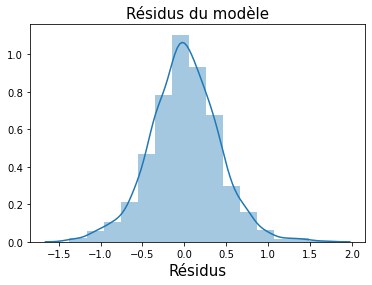

In [201]:
# L'histogramme des résidus
import seaborn as sns
resid = reg_multi.resid
fig = plt.figure()
sns.distplot(resid, bins = 15)
plt.title('Résidus du modèle', fontsize = 15)
plt.xlabel('Résidus', fontsize = 15)
plt.show()

Ici, l'hypothèse de normalité est remise en cause (p-value 0.000006 < 0.05).

Portant, si nous observons des résidus, ils ne sont pas très différents d'une distribution symétrique, et l'échantillon est de taille suffisante (supérieure à 30). Cela nous permet de dire que les résultats obtenus par le modèle linéaire gaussien ne sont pas absurdes, même si le résidu n'est pas considéré comme étant gaussien.

#### Prévision de la marge de bas par une regression linéaire
Si on souhaite prévoir la marge de bas en fonction des variables 'is_genuine' et 'margin_up' :

In [27]:
prevision = reg_multi.predict(billets)
billets.margin_low = billets.margin_low.fillna(prevision)

In [28]:
# Vérification de valeurs nulles
print(billets.isnull().sum())

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64


Maintenant, toutes les valeurs nulles sont remplacées par les valeurs prédites.

Ensuite, nous allons inspecter les valeurs abberantes et les valeurs doublon.

In [29]:
# Les valeurs aberrantes
billets.describe()
# Nous n'observons pas de valeurs abberantes

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.482863,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.659849,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.027500,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


In [30]:
# Les valeurs doublon
# Nous enlevons les lignes doublons et comparer les nombres de lignes avec la table d'origine 
billets_dedupped = billets.drop_duplicates()

print(billets.shape)
print(billets_dedupped.shape)
billets.nunique()
# Nous n'avons pas de lignes doublons

(1500, 7)
(1500, 7)


is_genuine        2
diagonal        159
height_left     155
height_right    170
margin_low      316
margin_up       123
length          336
dtype: int64

Nous n'avons pas de valeurs abberantes et de valeurs doublons.

##  <span style='color:blue'> II. Analyse descriptive des données <a class="anchor" id="Analyse"></a>

Nous allons voir maintenant la répartition des dimensions des billets par groupe (vraix / faux), et la distribution des billets en fonction de caractéristiques géometriques par groupe (vrais / faux).

Ensuite, nous allons effectuer un clustering et une ACP pour visualiser et mieux comprendre les spécificités de dimensions des billets par groupe.

### 2.1 Répartition des dimensions des billets par groupe (vraix / faux) <a class="anchor" id="rep"></a>
Tout d'abord, pour la variable diagonal :

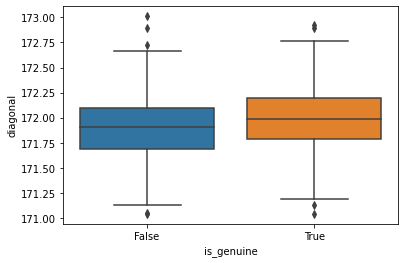

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.boxplot(y="diagonal", x="is_genuine", data=billets) ; plt.show()

Il semble bien que la répartition des dimensions diagonales est bien différente par groupe (False/True) : le groupe True a des valeurs plus grandes pour les valeurs de minimum, Q1, médian, Q3 et maximum. Nous allons vérifier cela par l'analyse de la variance à un facteur (ANOVA).

In [31]:
# L’analyse de la variance à un facteur (ANOVA) 
# Si la variable is_genuine n’a pas d’influence sur les dimensions diagonal, alors les moyennes de dimension diagonal par catégorie devraient être identiques.
# Test suit une loi de Fisher
import statsmodels.api
result_1 = statsmodels.formula.api.ols('diagonal ~ is_genuine', data = billets).fit()
tbl_1 = statsmodels.api.stats.anova_lm(result_1)
tbl_1

,df,sum_sq,mean_sq,F,PR(>F)
is_genuine,1.0,2.460749,2.460749,26.874763,2.466867e-07
Residual,1498.0,137.162201,0.091564,NaN,NaN


PR(>F) = P-valeur est < 0,01 : seuil d'1%, donc nous allons rejeter l'hypothèse nulle H0 (pas de corrélation entre les deux variables).

Nous concluons donc que la variable diagonal a une influence sur la variable is_genuine. Les moyennes de dimensions 'diagonal' sont differentes entre les faux billets les vrais billets.

Pour la variable height_left :

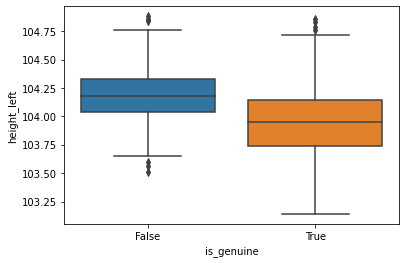

In [57]:
# height_left
ax1 = sns.boxplot(y="height_left", x="is_genuine", data=billets) ; plt.show()

Il semble bien que la répartition des dimensions height_left est bien différente par groupe (False/True) : l'interval entre les valeurs minimum et maximum est plus petit pour le groupe False. Ensuite le groupe False a des valeurs de minimum, Q1, médian, Q3 et maximum plus grandes par rapport au groupe True. Nous allons vérifier cela par l'analyse de la variance à un facteur (ANOVA).

In [58]:
# L’analyse de la variance à un facteur (ANOVA) 
# Test suit une loi de Fisher
result_2 = statsmodels.formula.api.ols('height_left ~ is_genuine', data = billets).fit()
tbl_2 = statsmodels.api.stats.anova_lm(result_2)
tbl_2

,df,sum_sq,mean_sq,F,PR(>F)
is_genuine,1.0,19.394088,19.394088,252.558393,1.126916e-52
Residual,1498.0,115.032185,0.076791,NaN,NaN


PR(>F) = P-valeur est < 0,01 : seuil d'1%, donc nous allons rejeter l'hypothèse nulle H0 (pas de corrélation entre les deux variables).

Nous concluons donc que la variable height_left a une influence sur la variable is_genuine. Les moyennes de dimension height_left sont differentes entre les faux billets les vrais billets.

Pour la variable height_right :

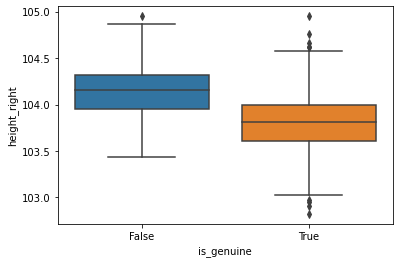

In [59]:
# height_right
ax2 = sns.boxplot(y="height_right", x="is_genuine", data=billets) ; plt.show()

Il semble bien que la répartition des dimensions height_right est bien différente par groupe (False/True) : les valeurs de minimum, Q1, médian, Q3 et maximum du groupe False sont plus grandes par rapport au groupe True. Nous allons vérifier cela par l'analyse de la variance à un facteur (ANOVA).

In [60]:
# L’analyse de la variance à un facteur (ANOVA) 
# Test suit une loi de Fisher
result_3 = statsmodels.formula.api.ols('height_right ~ is_genuine', data = billets).fit()
tbl_3 = statsmodels.api.stats.anova_lm(result_3)
tbl_3

,df,sum_sq,mean_sq,F,PR(>F)
is_genuine,1.0,37.401634,37.401634,460.974212,2.270856e-89
Residual,1498.0,121.541825,0.081136,NaN,NaN


PR(>F) = P-valeur est < 0,01 : seuil d'1%, donc nous allons rejeter l'hypothèse nulle H0 (pas de corrélation entre les deux variables).

Nous concluons donc que la variable height_right a une influence sur la variable is_genuine. Les moyennes de dimensions height_right sont differentes entre les faux billets et les vrais billets.

Pour la variable margin_low :

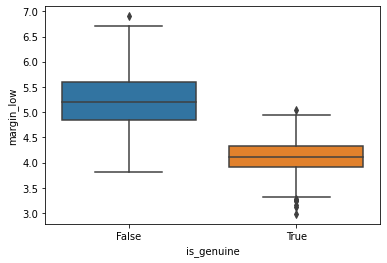

In [61]:
# margin_low
ax3 = sns.boxplot(y="margin_low", x="is_genuine", data=billets) ; plt.show()

Il semble bien que la répartition des dimensions margin_low est bien différente par groupe (False/True) : l'interval entre les valeurs minimum et maximum est plus petit pour le groupe True. Ensuite les valeurs de minimum, Q1, médian, Q3 et maximum du groupe False sont plus grandes par rapport au groupe True. Nous allons vérifier tout cela par l'analyse de la variance à un facteur (ANOVA).

In [62]:
# L’analyse de la variance à un facteur (ANOVA) 
# Test suit une loi de Fisher
result_4 = statsmodels.formula.api.ols('margin_low ~ is_genuine', data = billets).fit()
tbl_4 = statsmodels.api.stats.anova_lm(result_4)
tbl_4

,df,sum_sq,mean_sq,F,PR(>F)
is_genuine,1.0,403.359234,403.359234,2423.649755,2.336934e-315
Residual,1498.0,249.306704,0.166426,NaN,NaN


PR(>F) = P-valeur est < 0,01 : seuil d'1%, donc nous allons rejeter l'hypothèse nulle H0 (pas de corrélation entre les deux variables).

Nous concluons donc que la variable margin_low a une influence sur la variable is_genuine. Les moyennes de dimensions margin_low sont differentes entre les faux billets et les vrais billets.

Pour la variable margin_up :

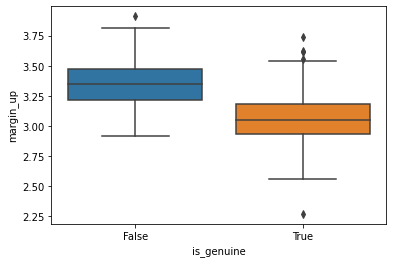

In [63]:
# margin_up
ax4 = sns.boxplot(y="margin_up", x="is_genuine", data=billets) ; plt.show()

Il semble bien que la répartition des dimensions margin_up est bien différente par groupe (False/True) : les valeurs de minimum, Q1, médian, Q3 et maximum du groupe False sont plus grandes par rapport au groupe True. Nous allons vérifier cela par l'analyse de la variance à un facteur (ANOVA).

In [64]:
result_5 = statsmodels.formula.api.ols('margin_up ~ is_genuine', data = billets).fit()
tbl_5 = statsmodels.api.stats.anova_lm(result_5)
tbl_5

,df,sum_sq,mean_sq,F,PR(>F)
is_genuine,1.0,29.607294,29.607294,870.581394,3.144530e-151
Residual,1498.0,50.944950,0.034009,NaN,NaN


PR(>F) = P-valeur est < 0,01 : seuil d'1%, donc nous allons rejeter l'hypothèse nulle H0 (pas de corrélation entre les deux variables).

Nous concluons donc que la variable margin_up a une influence sur la variable is_genuine. Les moyennes de dimensions margin_up sont differentes entre les faux billets et les vrais billets.

Pour la variable length :

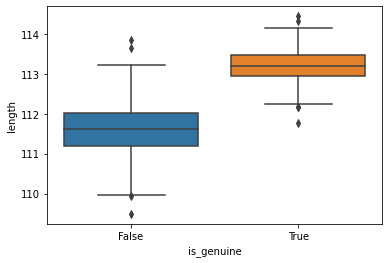

In [65]:
# length
ax5 = sns.boxplot(y="length", x="is_genuine", data=billets) ; plt.show()

Il semble bien que la répartition des dimensions length est bien différente par groupe (False/True) : l'interval entre les valeurs minimum et maximum sont plus petit pour le groupe True, ensuite il existe une grande écart entre les valeurs de minimum, Q1, médian, Q3 et maximum du groupe True et celles du groupe False (celles de groupe True grandes). Nous allons vérifier cela par l'analyse de la variance à un facteur (ANOVA).

In [66]:
result_6 = statsmodels.formula.api.ols('length ~ is_genuine', data = billets).fit()
tbl_6 = statsmodels.api.stats.anova_lm(result_6)
tbl_6

,df,sum_sq,mean_sq,F,PR(>F)
is_genuine,1.0,823.507935,823.507935,3876.654138,0.0
Residual,1498.0,318.216390,0.212427,NaN,NaN


PR(>F) = P-valeur est de 0 (< 0,01 : seuil d'1%), donc nous allons rejeter l'hypothèse nulle H0 (pas de corrélation entre les deux variables).

Nous concluons donc que la variable length a une influence sur la variable is_genuine. Les moyennes de dimensions length sont differentes entre les faux billets et les vrais billets.

### 2.2 Distribution des billets en fonction des caractéristiques géométriques par groupe (vrais / faux) <a class="anchor" id="dist"></a>
Nous allons d'abord voir le nombre de faux billets et vrais billets.

In [48]:
# Le nombre de faux / vrais billets
nb_f_v = billets.groupby(['is_genuine'],as_index=False).count()
total = nb_f_v['diagonal'].sum()
nb_f_v = nb_f_v.assign(proportion = ((nb_f_v['diagonal'] / total)*100))
nb_f_v = nb_f_v.rename(columns={'diagonal':'nombre'})
nb_f_v[['is_genuine','nombre','proportion']]

,is_genuine,nombre,proportion
0,False,500,33.333333
1,True,1000,66.666667


Nous allons maintenant regarder la distribution des dimensions de billets par caractéristique et par groupe.

Pour diagonal :

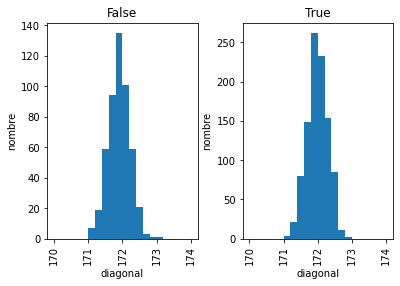

In [68]:
# diagonal : histogramme

ax = billets.hist(column='diagonal',by='is_genuine',bins=20,range=(170,174))
  
# labels
ax[0].set_xlabel('diagonal')
ax[0].set_ylabel('nombre')
ax[1].set_xlabel('diagonal')
ax[1].set_ylabel('nombre')
plt.show()

La distribution se ressemble pour les deux groupes, pourtant le nombre de billets baisse plus graduellemet si on éloigne de 172 pour les vraix billets.

Pour height-left :

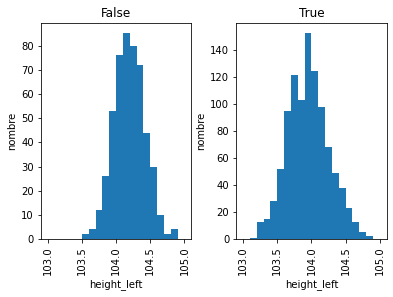

In [69]:
# height_left : histogramme
ax_1 = billets.hist(column='height_left',by='is_genuine',bins=20,range=(103,105))
  
# labels
ax_1[0].set_xlabel('height_left')
ax_1[0].set_ylabel('nombre')
ax_1[1].set_xlabel('height_left')
ax_1[1].set_ylabel('nombre')
plt.show()

La moyenne de dimension de faux billets est plus grande par rapport à celle de vraix billets, puis la distribution de faux billets est moins aplatie par rapport à celle de vrai billets.

Pour height_right :

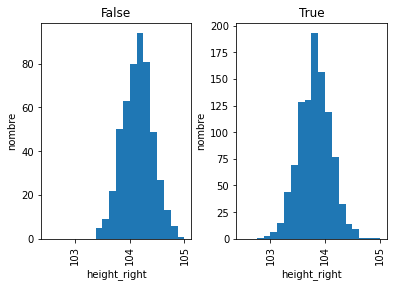

In [70]:
# height_right : histogramme

ax_2 = billets.hist(column='height_right',by='is_genuine',bins=20,range=(102.5,105))
  
# labels
ax_2[0].set_xlabel('height_right')
ax_2[0].set_ylabel('nombre')
ax_2[1].set_xlabel('height_right')
ax_2[1].set_ylabel('nombre')
plt.show()

La moyenne de dimension est plus grande pour les faux billets, et la distribution est deplacée vers la droite par rapport à celle de vraix billets. Enfin les vraix billets ont plus de range de dimensions. 

Pour margin_low : 

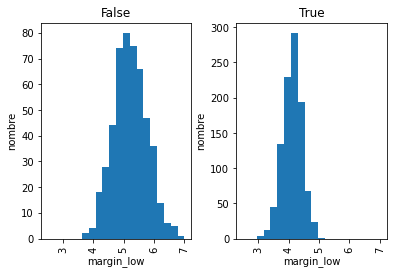

In [71]:
# margin_low : histogramme

ax_3 = billets.hist(column='margin_low',by='is_genuine',bins=20,range=(2.5,7))
  
# labels
ax_3[0].set_xlabel('margin_low')
ax_3[0].set_ylabel('nombre')
ax_3[1].set_xlabel('margin_low')
ax_3[1].set_ylabel('nombre')
plt.show()

La distribution est beaucoup plus centrée autours de 4 pour les vraix billets alors que pour les faux billets autours de 5. La distribution beaucoup moins étalée pour les vraix billets par rapport à celle de faux billets.

Pour margin_up :

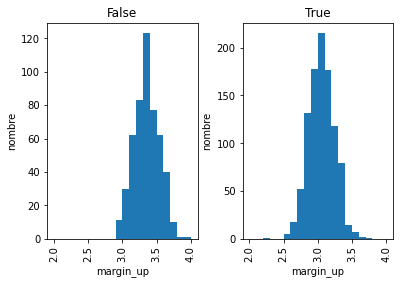

In [72]:
# margin_up : histogramme

ax_4 = billets.hist(column='margin_up',by='is_genuine',bins=20,range=(2,4))
  
# labels
ax_4[0].set_xlabel('margin_up')
ax_4[0].set_ylabel('nombre')
ax_4[1].set_xlabel('margin_up')
ax_4[1].set_ylabel('nombre')
plt.show()

La distribution est centrée vers 3,4 pour les faux billets alors que 3,0 pour les vrais billets.

Pour length :

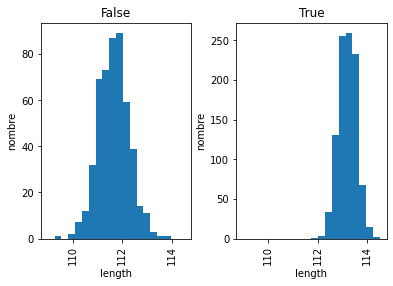

In [73]:
# length : histogramme

ax_5 = billets.hist(column='length',by='is_genuine',bins=20,range=(109,114.5))
  
# labels
ax_5[0].set_xlabel('length')
ax_5[0].set_ylabel('nombre')
ax_5[1].set_xlabel('length')
ax_5[1].set_ylabel('nombre')
plt.show()

La distribution est centrée vers 111,8 pour les faux billets alors que 113,8 pour les vraix billets. Ensuite la forme de distribution n'est pas identique : pour les vrais billets la distribution est beaucoup moins étalée.



### 2.3 Clustering et analyse de centroïdes <a class="anchor" id="clustering"></a>
Nous allons maintenant effectuer un clustering pour mieux comprendre les specificités de chaque groupe : False et True.

Tout d'abord nous allons transformer les données en centrées réduites, ensuite nous allons définir le nombre de groupes (clusters) optimal, et enfin nous allons effectuer un clustering par la méthode K-means.

In [32]:
# Préparation de clustering
billets1 = billets[{'diagonal','height_left','height_right','margin_low','margin_up','length'}]
billets1

,diagonal,height_left,margin_up,margin_low,length,height_right
0,171.81,104.86,2.89,4.52,112.83,104.95
1,171.46,103.36,2.99,3.77,113.09,103.66
2,172.69,104.48,2.94,4.40,113.16,103.50
3,171.36,103.91,3.01,3.62,113.51,103.94
4,171.73,104.28,3.48,4.04,112.54,103.46
...,...,...,...,...,...,...
1495,171.75,104.38,3.09,4.42,111.28,104.17
1496,172.19,104.63,3.37,5.27,110.97,104.44
1497,171.80,104.01,3.36,5.51,111.95,104.12
1498,172.06,104.28,3.46,5.17,112.25,104.06


In [33]:
# Nous allons transformer les valeurs en centrées réduites
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(billets1)

[0.34345999 0.21073363 0.19648827 0.15673904 0.14907835 0.14683076
 0.14528522 0.13834731 0.14276153]


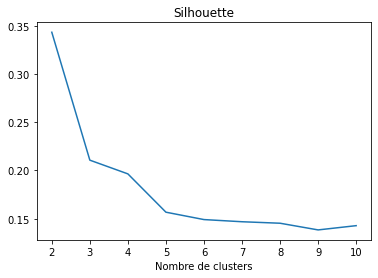

In [34]:
# Nous allons choisir le bon nombre de groupe
# librairie pour l'évaluation des partitions
from sklearn import metrics
from sklearn.cluster import KMeans
# utilisation de la métrique "silhouette"
# faire varier le nombre de clusters de 2 à 10
res = np.arange(9,dtype="double")   # arange : Renvoie des valeurs régulièrement espacées dans un intervalle donné. 
                                    # dtype : Le type du tableau de sortie.
for k in np.arange(9):
  km = KMeans(n_clusters=k+2)
  km.fit(X_scaled)
  res[k] = metrics.silhouette_score(X_scaled,km.labels_)
print(res)

#graphique
plt.title("Silhouette")
plt.xlabel("Nombre de clusters") # y label : score de silhouette : si plus haut les clusters sont plus proches à l'intérieur du groupe
plt.plot(np.arange(2,11,1),res)
plt.show()
# Bon nombre : Qualité semble optimale pour le nombre de 2

Nous voyons que le coefficient de silhouette est le plus elevée pour le nombre de 2, donc nombre de cluster optimal est de 2.

Nous allons effectuer un clustering par la méthode K-means :

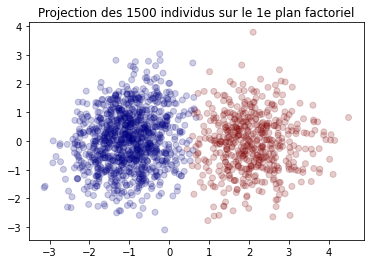

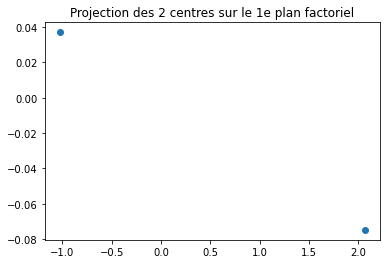

In [39]:
# Clustring par k-means, ensuite effectuer ACP pour pouvoir afficher en premier plan factoriel (2D)
from sklearn.decomposition import PCA

# Nombre de clusters souhaités
n_clust = 2

# Clustering par K-means
km = KMeans(n_clusters= n_clust)
km.fit(X_scaled)

# Récupération des clusters attribués à chaque individu
clusters = km.labels_

# Affichage du clustering par projection des individus sur le prmeier plan factoriel
pca = PCA(n_components=2).fit(X_scaled) # Nombre idéal de components est de 2 (c.f. partie ACP)
X_projected = pca.transform(X_scaled)
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=clusters.astype(np.float), cmap = 'jet', alpha=.2) # 1er plan factoriel
plt.title("Projection des {} individus sur le 1e plan factoriel".format(X_projected.shape[0]))
plt.show(block=False)

plt.figure()
centroids = km.cluster_centers_
centroids_projected = pca.transform(centroids)
plt.scatter(centroids_projected[:,0],centroids_projected[:,1])
plt.title("Projection des {} centres sur le 1e plan factoriel".format(len(centroids)))
plt.show()

Nous voyons bien deux couleurs distinctes et bien séparés en deux parties à gauche et à droite. 

Si nous affichons la liste des individus par groupe constitué :

In [40]:
# Liste des billets sous deux groupes : 
# Index triés des groupes
idk = np.argsort(km.labels_)

# Affichage des observations et leurs groupes
liste = pd.DataFrame({"Index billets" : billets.index[idk], "TF" :billets.is_genuine[idk], "groupe" : km.labels_[idk]})
liste

,Index billets,TF,groupe
749,749,True,0
665,665,True,0
666,666,True,0
667,667,True,0
668,668,True,0
...,...,...,...
1156,1156,False,1
1155,1155,False,1
1154,1154,False,1
1168,1168,False,1


In [41]:
# nombre de groupe 0 (True)
true = liste.query('groupe == "0"')
nbtrue = len(true)
print("Il existe", nbtrue, "individus dans le groupe True")

Il existe 1003 individus dans le groupe True


In [42]:
# nombre de False dans le groupe 0 (True)
false1 = true.query('TF == False')
nbff = len(false1)
print("Il existe", nbff, "billets False dans le groupe True")

Il existe 13 billets False dans le groupe True


In [43]:
print('{:.1f}%'.format((nbff/nbtrue)*100), "du groupe 0 (groupe True) sont des faux billets")

1.3% du groupe 0 (groupe True) sont des faux billets


In [44]:
# nombre de groupe 1 (False)
false = liste.query('groupe == "1"')
nbfalse = len(false)
print("Il existe", nbfalse, "individus dans le groupe False")

Il existe 497 individus dans le groupe False


In [45]:
# nombre de True dans le groupe 1
true1 = false.query('TF == True')
nbft = len(true1)
print("Il existe", nbft, "billets True dans le groupe False")

Il existe 10 billets True dans le groupe False


In [46]:
print('{:.1f}%'.format((nbft/nbfalse)*100), "du groupe 1 (groupe False) sont des faux billets")

2.0% du groupe 1 (groupe False) sont des faux billets


In [49]:
# c.f. : Le vrai nombre de faux / vrais billets
nb_f_v[['is_genuine','nombre','proportion']]

,is_genuine,nombre,proportion
0,False,500,33.333333
1,True,1000,66.666667


Les pourcentages de faux positive/négative sont très petits. Nous pouvons dire que le résultat de clustering est plutôt fiable.


#### Analyse de centroïdes
Nous allons maintenant regarder plus en détail les specificités de deux groupes constitués : plus spécifiquement nous allons effectuer l'analyse des centroïdes. 

In [51]:
# Analyse des centroïde
billets['Index billets']= billets.index
pd.options.display.float_format = '{:.2f}'.format
groupe = pd.merge(billets, liste, on = ['Index billets'])
moyenne = groupe.groupby(['groupe'], as_index=False).mean()
moyenne = moyenne[{'diagonal','height_left','height_right','margin_low','margin_up','length'}]
moyenne
# 0 : True, 1 : False

,diagonal,height_left,margin_up,margin_low,length,height_right
0,171.99,103.95,3.05,4.12,113.20,103.81
1,171.90,104.20,3.35,5.22,111.63,104.15


In [52]:
# Calcul de la moyenne globale
gbm = groupe.mean()
gbm = gbm[{'diagonal','height_left','height_right','margin_low','margin_up','length'}]
gbm

diagonal       171.96
height_left    104.03
margin_up        3.15
margin_low       4.48
length         112.68
height_right   103.92
dtype: float64

##### Groupe True
* Les moyennes de diagonal et length sont plus grandes par rapport aux moyennes globales.

##### Groupe False
* Les moyennes de margin_up, height_right, height_left sont plus grandes par rapport aux moyennes globales, la moyenne de margin_low est particulièrement grande par rapport à la moyenne globale. Enfin length est particulièremant petite par rapport à la moyenne globale.






### 2.4 ACP <a class="anchor" id="acp"></a>
Nous allons maintenant effectuer l'ACP pour visualiser au mieux les résultats obtenus.

Nous allons d'abord déterminer le nombre opmtimal de composantes principales en vérifiant l'inertie de chaque axe. Ensuite nous allons vérifier le pourcentage des données expliquées à partir de composantes principales par rapport aux données originales. 

[2.59229607 1.01742822 0.78119661 0.70951099 0.58001469 0.31955341]


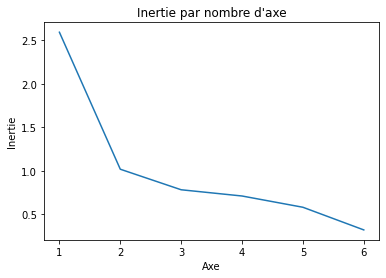

In [53]:
# Inertie de chaque axe : de l'axe 1 à l'axe 5
# Nous conservons l'axe ayant les axes apportant une inertie supérieure à l'inertie moyenne = I total/P, c'est à dire 1. 

pca = PCA(n_components=6).fit(X_scaled)

n = 1500 # nombre de billets
inertie = (n-1)/n*pca.explained_variance_
print(inertie)

# En graphique : Inertie selon le nombre d'axe  
x = np.linspace(1, 6, 6)
plt.xticks([1,2,3,4,5,6])
plt.plot(x, inertie)
plt.title("Inertie par nombre d'axe")
plt.xlabel("Axe")
plt.ylabel("Inertie")
plt.show() 
# Nous gardons jusqu'au 2ème axe

Nous avons ici une inertie supérieure à 1 (c'est à dire l'inertie moyenne) jusqu'à la deuxième composante principale. Donc nous allons garder deux composantes principales.

Nous allons vérifier le pourcentage d'inertie expliqué par ces deux composantes principales à partir de l'éboulis des valeurs propres.

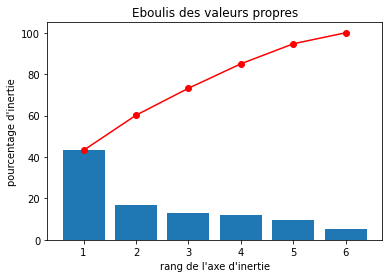

In [54]:
# Eboulis des valeurs propres

from sklearn import decomposition
from sklearn import preprocessing

# choix du nombre de composantes à calculer
n_comp = 6 # Nombre de variables existantes

# préparation des données pour l'ACP
names = billets1.index
features = billets1.columns

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Eboulis des valeurs propres
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie") # Cumul de variance expliquée
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)
display_scree_plot(pca)
# Nombre de components optimal : 2 (Quand le nombre de dimensions est de 2, % d'inertie atteint environ 62 %.)
# Y= % d'inertie : % cumulé de la variance expliquée
# X = Dimensions

Avec deux composantes principales, nous pouvons expliquer 60,2 % des données initiales sur le premier plan factoriel (F1 43,2%, F2 17%).

Nous allons maintenant regarder la cercle de corrélation pour interpréter les variables et voir le lien entre les variables.

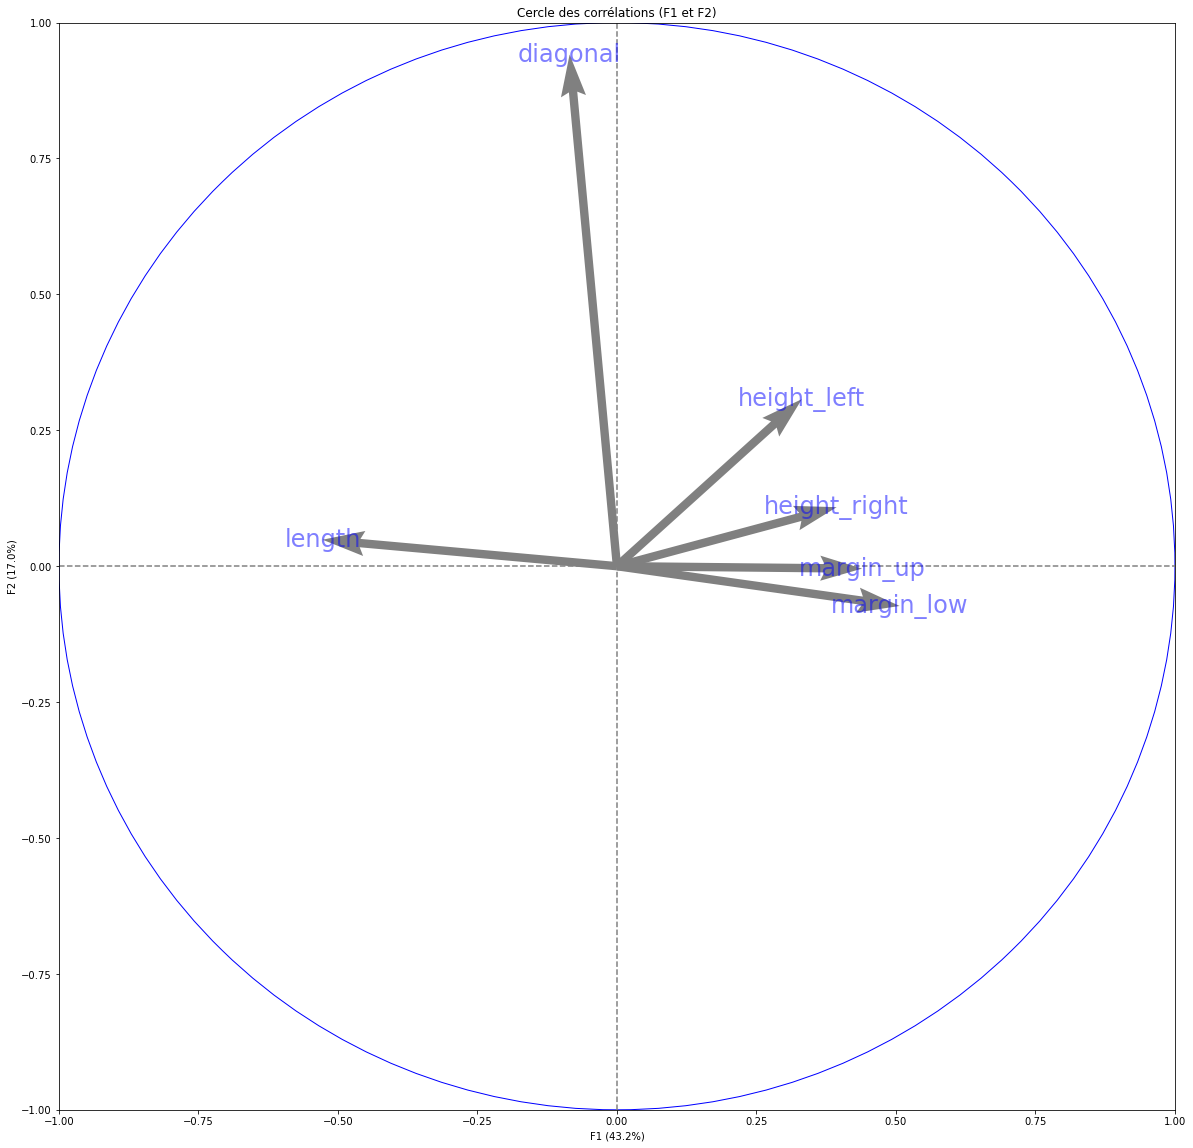

In [55]:
# cercle de corrélation
# Cercle des corrélations
# Les liens entre les variables
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche le premier plan factoriel, donc les 2 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(20,20))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 : # Si moins de 30 colonnes (shape[1] : nombre de colonne)
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # np.zero : origine (0,0), pcs.shape[1] : combient de flèche à tracer 
                # (Tracer un champ de flèches 2D (endroit, direction, autres parametres) : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
                # xy : c'est un coordonné (x,y), scale : diviser par 1. Si 2, graphique trace 1/2 de longeur.
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black')) # Trance des lignes
            
            # affichage des noms des variables  
            if labels is not None:
                for i,(x, y) in enumerate(pcs[[d1,d2]].T): 
                    # enumerate : permet de donner les valeurs de i (index) et les veleurs de x et y, si il n'y a pas enumerate, cela nous donne que x et y
                    # pcs[[d1,d2]].T = coordonnée de chaque flèche d1 d2, T = transposé
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='24', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle) # afficher quelque chose dans le graphique courant

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
  

pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features)) # labels = np.array(features) : nom de colonnes

In [56]:
# Contribution d'une variable à un axe
# Colonne : 6 Variables diagonal, height_left, margin_up, margin_low, length, height_right     
# Lignes : de F1 à F6 
print(pca.components_)

[[-0.08483969  0.33133251  0.43931716  0.50658472 -0.52758454  0.39376123]
 [ 0.94130571  0.30725488 -0.00442827 -0.07316255  0.04870577  0.10859729]
 [-0.28703124  0.88479214 -0.2709382  -0.10699285  0.14979785 -0.16571532]
 [-0.10282238 -0.047614   -0.44267713 -0.09139172  0.17723563  0.86685207]
 [-0.11716078  0.10320227  0.71051535 -0.57099545  0.30085264  0.23290013]
 [ 0.00773041  0.00618687  0.18104754  0.62624552  0.75823355  0.0047098 ]]


In [63]:
# Qualuté de représentation : cosinus carré des variables

# Racine carrée des valeurs propres
sqrt_eigval = np.sqrt(eigval)  
                                
# Corrélation des variables avec les axes
p = 6
corvar = np.zeros((p,p))
for k in range(p): # boucle plage p
    corvar[:,k] = pca.components_[k,:] * sqrt_eigval[k]

# Cosinus carré des variables
cos2var = corvar**2
pd.DataFrame({'Index':features,'COS2_1':cos2var[:,0],'COS2_2':cos2var[:,1]})

,Index,COS2_1,COS2_2
0,diagonal,0.02,0.90
1,height_left,0.28,0.10
2,margin_up,0.50,0.00
3,margin_low,0.67,0.01
4,length,0.72,0.00
5,height_right,0.40,0.01


##### Interprétation des variables, lien entre les variables
* **1er axe** :

Sur le 1er axe, les variables margin_up, margin_low et length sont les principales variables ayant contribuées à la création de cet axe. Les deux variables margin_up et margin_low sont fortement corrélées positivement. Ces deux variables sont également relativement bien représentées ayant les valeurs de cosinus carré relativement important. Ces deux variables sont proches l'une à l'autre en constituant un groupe de variables sur le 1er axe. Ces variables sont en opposition (corrélées négativement) avec une variables length qui est également relativement bien représentée sur l'axe 1. L'axe 1 est resumé par ces trois variables qui met evidence de **la dimension de length, marge de haut et marge de bas**.

Les trois autres variables ('diagonal', 'height_right' et 'height_left') sont mal représentées sur le 1er axe. Ensuite, ces variables sont non corrélées avec les trois variables margin_up, margin_low et length.


* **2eme axe** :

Sur le 2eme axe, la variable 'diagonal' est la principale variable ayant contribué à la création de cet axe. Cette variable est  bien représentée ayant la valeur de cosinus carré importante (proche de 1).

Cette variable explique principalement le 2eme axe. Il n'existe pas de variables en opposition avec cette variable sur l'axe 2. L'axe 2 est resumé par cette variable qui met evidence de **la dimension diagonal**.

Les cinq autres variables (margin_up, margin_low, length, 'height_right' et 'height_left') sont mal représentées sur le 2eme axe, ces variables sont non corrélées avec la variable diagonal.




Nous allons maintenant projeter les individus pour voir le lien entre les individus.

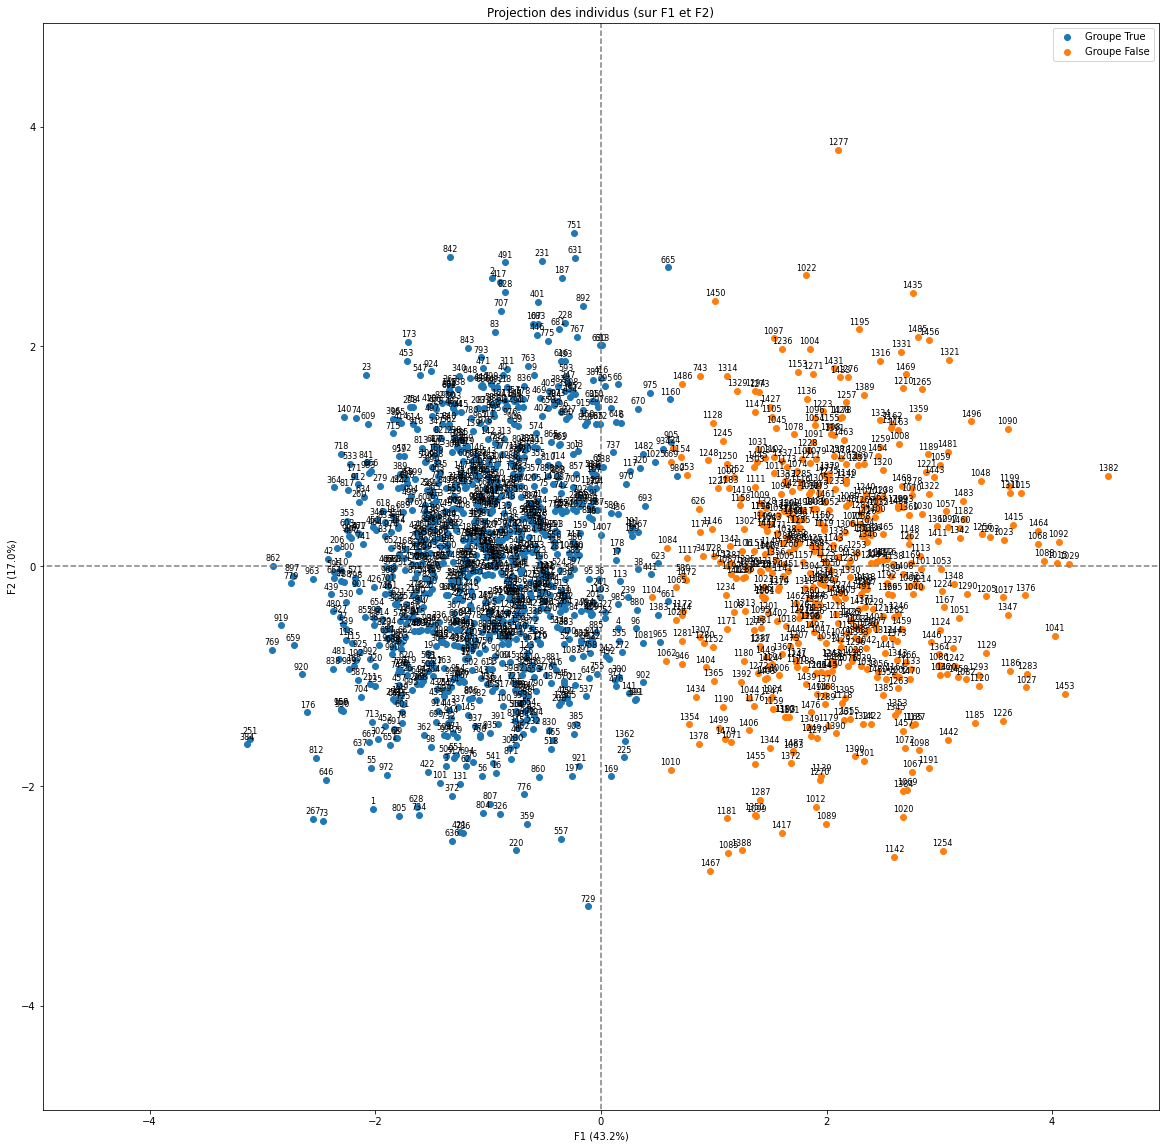

In [194]:
# Projection des individus
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None): # alpha : transparence d'un graphique
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(20,20))
            
            # Nom de groupes
            Groupelabel = {0 : 'Groupe True', 1 : 'Groupe False'} 
            
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], c=colors.cat.codes, alpha=alpha) # colors.cat.codes : colorer par groupe
            else:
                for value in np.unique(illustrative_var): # value : 0,1, illustrative_var : la colonne 'groupe' de la 'liste' 
                    selected = np.where(illustrative_var == value) # selected : par numéro de groupe, on a un tableau True/False, filtre de valeur
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=Groupelabel[value]) # projeter la valeur si True dans selected
                               
            plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]): #  # enumerate : permet de donner les valeurs de i (index) et les veleurs de x et y, si il n'y a pas enumerate, cela nous donne que x et y

                    plt.text(x, y+0.03, labels[i],
                              fontsize='8', ha='center',va='bottom') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))
            
            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
     
            
X_projected = pca.transform(X_scaled)
listetrie = liste.sort_values(by = 'Index billets', ascending = True)
listetrie = listetrie.reset_index()
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], 
                         labels = listetrie.iloc[:,1], 
                         illustrative_var= listetrie.iloc[:,3] 
                        )

In [59]:
# Contribution à la formation de l'axe : (vérifier que ce n'est pas une seule variable qui a construit cet axe, ou bien garder que les variables ayant plus de contribution moyen : 1/n ou 1/P)
# La contribution (en pourcentage) de l'individu i à la composante c j est défnie par
# ((1/n*cji²) / λj) × 100 

from sklearn.decomposition import PCA
#nombre d'observations
n = 1500
p = 6

acp = PCA(svd_solver='full') # full : Exécuter exactement le SVD complet en appelant le solveur LAPACK standard via scipy.linalg.svd et sélectionner les composants par post-traitement
# SVD : Réduction de dimension linéaire à l'aide de la décomposition en valeurs singulières des données pour les projeter dans un espace de dimension inférieure.

coord = acp.fit_transform(X_scaled) # Appliquer la réduction de dimension sur X_scaled
eigval = (n-1)/n*acp.explained_variance_

ctr = coord**2
for j in range(p):
 ctr[:,j] = ctr[:,j]/(n*eigval[j])

# Pour l'axe 1
contribution = pd.DataFrame({'Index':billets1.index,'CTR_1':ctr[:,0],'CTR_2':ctr[:,1]})
contribution.sort_values(by = 'CTR_1', ascending = False)

,Index,CTR_1,CTR_2
1382,1382,0.01,0.00
1029,1029,0.00,0.00
1453,1453,0.00,0.00
1092,1092,0.00,0.00
1015,1015,0.00,0.00
...,...,...,...
1103,1103,0.00,0.00
241,241,0.00,0.00
672,672,0.00,0.00
1407,1407,0.00,0.00


In [60]:
# Pour l'axe 2
contribution.sort_values(by = 'CTR_2', ascending = False)

,Index,CTR_1,CTR_2
1277,1277,0.00,0.01
729,729,0.00,0.01
751,751,0.00,0.01
842,842,0.00,0.01
631,631,0.00,0.01
...,...,...,...
688,688,0.00,0.00
1230,1230,0.00,0.00
403,403,0.00,0.00
1087,1087,0.00,0.00


In [61]:
# Qualité de représentation des individus - COS2
cos2 = coord**2
di = np.sum(X_scaled**2,axis=1)

for j in range(p):
 cos2[:,j] = cos2[:,j]/di
qualiterep_ind = pd.DataFrame({'index':billets1.index,'COS2_1':cos2[:,0],'COS2_2':cos2[:,1]})

# Pour l'axe 1
print("Moyenne de COS² sur l'axe 1 est de", '{:.2f}'.format(qualiterep_ind['COS2_1'].mean()))

Moyenne de COS² sur l'axe 1 est de 0.39


In [62]:
# Pour l'axe 2
print("Moyenne de COS² sur l'axe 2 est de", '{:.2f}'.format(qualiterep_ind['COS2_2'].mean()))

Moyenne de COS² sur l'axe 2 est de 0.18


##### Analyse des individus
Nous n'avons pas ici d'individus ayant de trop forte contribution à la création d'axes (maximum est un individus ayant une valeur de 0.01 pour l'axe 1, et aussi certains individus ayant 0.01 pour l'axe 2). Cela signifie qu'aucun de ces deux axes n'ont été crées par seulement une partie d'individus ayant trop fortes valeurs. Pour la qualité de représentation des individus de deux axes, nous mesurons à partir de Cos² : s'il est proche de 1, les individus sont bien représentés et la proximité entre les deux individus sont réelles, et cette proximité traduit leur ressemblance. Nous avons ici 0.39 pour l'axe 1 et 0.18 pour l'axe 2 en moyenne, donc sur le 1er plan factoriel nous avons la valeur de Cos² d'environ 0.6.


Si nous analysons les liens entre les individus :

* **Sur le 1er axe** :

les individus à droite de l'axe central ont une valeur de margin_up et margin_low plus elevées que la moyenne. Plus les individus sont situés à droite, plus ces individus ont une valeur forte pour ces deux variables. Ensuite les individus à gauche de l'axe central ont une valeur de length plus elevée que la moyenne. Plus les individus sont situés à gauche, plus ces individus ont une valeur forte de length.


* **Sur le 2eme axe** : 

les individus au dessus de l'axe central ont une valeur de diagonal plus elevée que la moyenne. Plus les individus sont situés en haut, plus ces individus ont une valeur forte de la dimension diagonal. 


* **Ensemble du 1er plan factoriel** :

Nous remarquons que les individus de groupe True se situent plus vers la gauche, c'est à dire que la valeur de length est plus élevée et les valeurs de margin_up et largin_low sont plus faibles. Ensuite les individus de groupe False se situent plus vers la droite, c'est à dire que la valeur de length est moins elevée et les valeurs de margin_up et margin_low sont plus élevées. Il ne semble pas que la variable diagonal affecte le groupement des individus dans les groupe de True et False.

##  <span style='color:blue'> III. Différentes pistes explorées pour la construction de l’algorithme <a class="anchor" id="algorithme"></a>

Nous allons maintenant voir les différentes pistes pour la construction de l'algorithme pour detecter les faux billets.
    
Nous allons d'abord séparer les données en training set (qui va nous permettre d’entraîner notre modèle et qui sera utilisé par l’algorithme d’apprentissage) et en testing set (qui permet de mesurer l’erreur du modèle final sur des données qu’il n’a jamais vues) : 80 % des données pour le training set et 20 % des données pour le testing set.

Ensuite, nous allons effectuer une régression logistique avec deux modèles (classique et K-NN), puis comparer leur matrice de confusion et leur taux d'erreurs.
    
### 3.1 Régression logistique classique <a class="anchor" id="reglog"></a>
Nous allons effectuer d'abord une régression logistique classique.

In [176]:
# Régression logistique avec "statsmodels"
# Avec les données d'apprentissage (Training set)

# Importation de la librairie de calcul
import statsmodels as sm
import sklearn
from sklearn.model_selection import train_test_split

# Préparation
yTrain = billets.iloc[:,0]
XTrain = billets.iloc[:,[1,2,3,4,5,6]]

# On divise les données d'apprentissage et données de test
xtrain1, xtest1, ytrain1, ytest1 = train_test_split(XTrain, yTrain, train_size=0.8, random_state = 1000)

#importation de l'outil
from statsmodels.tools import add_constant

#données X avec la constante
XTrainBis = sm.tools.add_constant(xtrain1)

#vérifier la structure
print(XTrainBis.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1200 entries, 1424 to 1459
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   const         1200 non-null   float64
 1   diagonal      1200 non-null   float64
 2   height_left   1200 non-null   float64
 3   height_right  1200 non-null   float64
 4   margin_low    1200 non-null   float64
 5   margin_up     1200 non-null   float64
 6   length        1200 non-null   float64
dtypes: float64(7)
memory usage: 75.0 KB
None


In [177]:
# Importation de la classe de calcul
from statsmodels.api import Logit

# Régression logistique - on passe la cible et les explicatives
lr = Logit(endog=ytrain1,exog=XTrainBis)

# lancer les calculs
# Algorithme de Newton-Raphson utilisé par défaut
# https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.Logit.fit.html
res = lr.fit()

# Résumé des résultats
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.026328
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                 1200
Model:                          Logit   Df Residuals:                     1193
Method:                           MLE   Df Model:                            6
Date:                Fri, 17 Sep 2021   Pseudo R-squ.:                  0.9580
Time:                        10:37:53   Log-Likelihood:                -31.594
converged:                       True   LL-Null:                       -751.49
Covariance Type:            nonrobust   LLR p-value:                5.872e-308
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -238.1842    279.551     -0.852      0.394    -786.095     309.726
diagonal         0.128

Nous enlevons les variables ayant leur p-valeur supérieur à 0.05 (leur parametre n'est pas significativement différent de 0).

In [178]:
# Enlever les colonnes ayant leur p-valeur > 0.5, recalculer les résultats
XTrainBis = XTrainBis.iloc[:,[0,3,4,5,6]]
lr = Logit(endog=ytrain1,exog=XTrainBis)
res = lr.fit()
print(res.summary()) # Modèle regression logistique

Optimization terminated successfully.
         Current function value: 0.027175
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                 1200
Model:                          Logit   Df Residuals:                     1195
Method:                           MLE   Df Model:                            4
Date:                Fri, 17 Sep 2021   Pseudo R-squ.:                  0.9566
Time:                        10:37:56   Log-Likelihood:                -32.610
converged:                       True   LL-Null:                       -751.49
Covariance Type:            nonrobust   LLR p-value:                4.495e-310
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -342.9837    156.563     -2.191      0.028    -649.842     -36.126
height_right    -2.600

Maintenant toutes les p-valeurs sont inférieurs à 0.05.

Nous allons maintenant regarder la matrice de confusion avec les données training set.

In [179]:
# Matrice de confusion en resubstitution
# L’évaluation en resubstitution consiste à utiliser les données d’apprentissage même pour mesurer la qualité du modèle
# La propriété (.fittedvalues) correspond aux valeurs du LOGIT calculées sur les données d’apprentissage

# Valeurs estimées par la régression en resubstitution
print(res.fittedvalues)

1424    -6.92
1216   -12.17
810      6.02
1298    -7.28
510      5.35
        ...  
350     12.20
1275    -7.94
71       8.00
599      8.60
1459   -18.15
Length: 1200, dtype: float64


In [180]:
# Nous pouvons déduire du LOGIT la prédiction en utilisant une règle d’affectation simple 
# la règle d'affectation consiste à confronter le LOGIT à la valeur seuil 0
predResub = np.where(res.fittedvalues > 0, 1, 0) # Si la valeur est plus grande que 0, alors 1 sinon 0.
print(predResub)

[0 0 1 ... 1 1 0]


In [181]:
# Matrice de confusion avec les données training set
# Via un tableau croisé entre les classes observées et prédites, nous obtenons la matrice de confusion.
mcSm = pd.crosstab(ytrain1,predResub)
print(mcSm)
# Lignes : observation, colonnes : prévision

col_0         0    1
is_genuine          
False       378    5
True          2  815


Nous voyons que 815 vrais billets sur 817 vraix billets ont été détéctés comme "vrais". 2 vrais billets sur 817 vrais billets ont été détéctés comme "faux".

Ensuite 378 faux billets sur 383 faux billets ont été détectés comme "faux", 5 faux billets sur 383 faux billets ont été détectés comme "vrai".

Nous allons maintenant regarder le taux d'erreur avec les données training set.

In [182]:
# Le taux d'erreur
# Transformer en matrice Numpy
mcSmNumpy = mcSm.values

#taux de reconnaissance
accSm = np.sum(np.diagonal(mcSmNumpy))/np.sum(mcSmNumpy)
# (Vraix positive + vraix négative) / n

#taux d'erreur
errSm = 1.0 - accSm
print("Taux d'erreur' : %.4f" % (errSm))

Taux d'erreur' : 0.0058


Nous allons maintenant regarder la matrice de confusion avec les données testing set.

In [183]:
# Matrice de confusion avec les données de test (testing set)

# données avec la constante
XTrainBis_test = sm.tools.add_constant(xtest1)

#vérifier la structure
print(XTrainBis_test.info()) # len(XTrainBis_test) = 300

# Enlever les colonnes différentes de Dataframe XTrainBis, puis regression logistique
XTrainBis_test = XTrainBis_test.iloc[:,[0,3,4,5,6]]

#la règle d'affectation consiste à confronter le LOGIT à la valeur seuil 0.5
res_test = res.predict(XTrainBis_test) # res = modèle
predResub_test = np.where(res_test > 0.5, 1, 0)

# Matrice de confusion
# Via un tableau croisé entre les classes observées et prédites, nous obtenons la matrice de confusion.
mcSm_test = pd.crosstab(ytest1,predResub_test)
print(mcSm_test)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 886 to 405
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   const         300 non-null    float64
 1   diagonal      300 non-null    float64
 2   height_left   300 non-null    float64
 3   height_right  300 non-null    float64
 4   margin_low    300 non-null    float64
 5   margin_up     300 non-null    float64
 6   length        300 non-null    float64
dtypes: float64(7)
memory usage: 18.8 KB
None
col_0         0    1
is_genuine          
False       114    3
True          0  183


Nous voyons que 183 vrais billets sur 183 vrais billets ont été détéctés comme "vrais". 0 vrai billets sur 184 vrais billets a été détécté comme "faux".

Ensuite 114 faux billets sur 117 faux billets ont été détectés comme "faux", 3 faux billets sur 117 faux billets ont été détectés comme "vrai".

Nous allons maintenant regarder le taux d'erreur avec les données testing set.

In [184]:
# Le taux d'erreur avec testing set

# Transformer en matrice Numpy
mcSmNumpy_test = mcSm_test.values

#taux de reconnaissance
accSm_test = np.sum(np.diagonal(mcSmNumpy_test))/np.sum(mcSmNumpy_test)
# (Vraix positive + vraix négative) / n

#taux d'erreur
errSm_test = 1.0 - accSm_test
print("Taux d'erreur' : %.4f" % (errSm_test))

Taux d'erreur' : 0.0100


### 3.2 Modèle K-NN <a class="anchor" id="knn"></a>
Nous allons maintenant construire une algorithme avec le modèle K-NN.

Le modèle k-NN consiste à choisir les k données les plus proches du point étudié afin d’en prédire sa valeur. Pour réaliser la prédiction, les centroïdes d'un k-means seront utilisés. Ce sont les classifications automatiques pour partitionner les données. Nous choisissons le bon nombre de voisins k en fonction de l’erreur de généralisation du modèle.

Source : https://openclassrooms.com/fr/courses/4011851-initiez-vous-au-machine-learning/4022441-entrainez-votre-premier-k-nn

Nous allons d'abord choisir le k optimal.

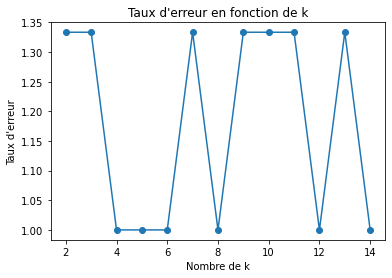

In [185]:
# Optimisation du score sur les données test
from sklearn import neighbors
errors = []
for k in range(2,15):
    knn = neighbors.KNeighborsClassifier(k)
    errors.append(100*(1 - knn.fit(xtrain1, ytrain1).score(xtest1,ytest1)))
plt.plot(range(2,15), errors, 'o-')
plt.title("Taux d'erreur en fonction de k")
plt.xlabel("Nombre de k")
plt.ylabel("Taux d'erreur")
plt.show()
# classifieur final optimal k = 5

Nous voyons que lorsque k = 5, le taux d'erreur est minimum sans avoir le k trop grand (k trop grand = augmenter le biais du modèle) ni trop petit (k trop petit = augmenter la variance du modèle), nous choisissons donc le k = 5.

Ensuite nous effectuons la prédiction avec le modèle 5-NN.

In [186]:
# On récupère le classifieur le plus performant
knn = neighbors.KNeighborsClassifier(5)
knn.fit(xtrain1, ytrain1) 

KNeighborsClassifier()

Maintenant nous allons voir la matrice de confusion avec les données de training set.

In [187]:
# Matrice de confusion avec les données d'apprentissage (training set)
predicted_ap = knn.predict(xtrain1)
print(pd.crosstab(ytrain1,predicted_ap))

col_0       False  True 
is_genuine              
False         376      7
True            2    815


Nou voyons que 815 vrais billets sur 817 vrais billets ont été détéctés comme "vrais". 2 vrais billets sur 817 vrais billets ont été détéctés comme "faux".
Ensuite 376 faux billets sur 383 faux billets ont été détectés comme "faux", 7 faux billets sur 383 faux billets ont été détectés comme "vrai".

Nous allons voir maintenant le taux d'erreur avec les données training set.

In [188]:
# Le taux d'erreur avec les données d'apprentissage
error = 1 - knn.score(xtrain1, ytrain1)
print('Erreur: %.4f' % error)

Erreur: 0.0075


Nous allons maintenant regarder la matrice de confusion avec les données testing set.

In [189]:
# Matrice de confusion avec les données de test (testing set)
predicted_test = knn.predict(xtest1)
print(pd.crosstab(ytest1,predicted_test))

col_0       False  True 
is_genuine              
False         114      3
True            0    183


Nous voyons que 183 vrais billets sur 183 vrais billets ont été détéctés comme "vrais". 0 vrai billet sur 183 vrais billets a été détécté comme "faux".

Ensuite 114 faux billets sur 117 faux billets ont été détectés comme "faux", 3 faux billets sur 117 faux billets ont été détectés comme "vrai".

Nous allons maintenant regarder le taux d'erreur avec les données de test.

In [190]:
# Le taux d'erreur avec les données de test
error_test = 1 - knn.score(xtest1, ytest1)
print('Erreur: %.4f' % error_test)

Erreur: 0.0100


##  <span style='color:blue'> IV. Modèle retenu <a class="anchor" id="model"></a>

Nous allons maintenant évaluer les deux algorithmes que nous avons construit pour choisir le modèle le plus performant pour identifier un maximum de faux billets au sein de la masse de billets analysés chaque jour. 

Pour cela, nous allons comparer les matrices de confusion et les taux d'erreur.

* **Modèle regression logistique classique** : 
 * **Training set** : 2 faux négative sur 817 vrais billets, et 5 faux positive sur 383 faux billets. Ensuite le **taux d'erreur** était de **0.0058**.
 * **Testing set** : 0 faux négative sur 183 vrais billets, et 3 faux positive sur 117 faux billets. Ensuite le **taux d'erreur** était de **0.01**.



* **Modèle 5_NN** :
 * **Training set** : 2 faux négative sur 817 vrais billets, et 7 faux positive sur 383 faux billets. Le **taux d'erreur** était de **0.0075**.
 * **Testing set** : 0 faux négative sur 183 vrais billets, et 3 faux positive sur 117 faux billets. Le **taux d'erreur** était de **0.01**.
 
Nous avons eu les mêmes taux d'erreurs de testing set pour les deux modèles. De plus, la matrice de confusion est également la même pour le testing set pour les deux modèles. Donc nous ne pouvons pas évaluer ces deux modèles à partir de leur testing set. Pourtant, si nous regardons la matrices de confusion de training set, le 1er modèle a eu le meilleur résultat : moins de nombre de prédiction pour les "faux positive (faux en réalité mais prédit comme vrai)", car il est plus grâve de prédire les faux billets comme vrais que prédire les vrais billets comme faux. De plus nous avons eu le meilleur taux d'erreur de training set pour le 1er modèle. Donc nous déterminons que le meilleur modèle est le 1er modèle, c'est à dire la **régression logistique classique**.

##  <span style='color:blue'> V. Test de l'algorithme <a class="anchor" id="test"></a>

Nous allons tester l'algorithme qu'on a choisi avec un jeu de données en csv fourni pour détecter les faux billets. 

In [193]:
# Test de l’algorithme en direct : changer le nom de fichier et lancer

echantillon = pd.read_csv("billets_production.csv", sep=",")

# Données avec la constante
echantillon = sm.tools.add_constant(echantillon)

# Vérifier la structure
print(echantillon.info())

# Enlever les colonnes différentes de Dataframe XTrainBis, puis regression logistique
echantillon = echantillon.iloc[:,[0,3,4,5,6]]

# La règle d'affectation consiste à confronter le LOGIT à la valeur seuil 0.5
res_echantillon = res.predict(echantillon) # res = modèle
resultat = np.where(res_echantillon > 0.5, True, False)
resultat

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   const         5 non-null      float64
 1   diagonal      5 non-null      float64
 2   height_left   5 non-null      float64
 3   height_right  5 non-null      float64
 4   margin_low    5 non-null      float64
 5   margin_up     5 non-null      float64
 6   length        5 non-null      float64
 7   id            5 non-null      object 
dtypes: float64(7), object(1)
memory usage: 448.0+ bytes
None


array([False, False, False,  True,  True])